# Random Forest


In [1]:
# Core
import numpy as np
import pandas as pd

# Visualización
import matplotlib.pyplot as plt
import seaborn as sns

# Modelado
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    confusion_matrix,
    classification_report,
    roc_auc_score,
    average_precision_score,
    precision_recall_curve
)




In [ ]:
# Carga de particiones
train_under = pd.read_csv("../data/bogie_train_under_1a5.csv")
valid       = pd.read_csv("../data/bogie_valid.csv")
test        = pd.read_csv("../data/bogie_test.csv")

## Definir X e y

In [4]:
# Columnas a excluir de las features
cols_to_exclude = [
    "timestamp",
    "train_id",
    "bogie_id",
    "target_fault",
    "alarm_level",
    "fault_type",
]

# Lista de columnas de entrada
all_cols = train_under.columns.tolist()
feature_cols = [c for c in all_cols if c not in cols_to_exclude]

print("Nº de features:", len(feature_cols))

# Construir X e y para cada conjunto
X_train = train_under[feature_cols].copy()
y_train = train_under["target_fault"].copy()

X_valid = valid[feature_cols].copy()
y_valid = valid["target_fault"].copy()


Nº de features: 28


Se usan solo sensores y contexto, dejando fuera ID, tiempo y variables que actúan como objetivos derivados.

In [ ]:
rf = RandomForestClassifier(
    n_estimators=300,
    max_depth=None,
    random_state=42,
    class_weight="balanced"  
)

rf.fit(X_train, y_train)

,n_estimators,300
,criterion,'gini'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [6]:
# Probabilidades y predicciones en valid
y_valid_proba = rf.predict_proba(X_valid)[:, 1]
y_valid_pred  = rf.predict(X_valid)  # umbral 0.5 por defecto

# Métricas
cm = confusion_matrix(y_valid, y_valid_pred)
roc = roc_auc_score(y_valid, y_valid_proba)
pr_auc = average_precision_score(y_valid, y_valid_proba)

print("Matriz de confusión (valid):\n", cm)
print("\nROC-AUC (valid):", roc)
print("PR-AUC  (valid):", pr_auc)
print("\nInforme clasificación (valid):")
print(classification_report(y_valid, y_valid_pred, digits=3))


Matriz de confusión (valid):
 [[28927     0]
 [  446     0]]

ROC-AUC (valid): 0.48834707779176934
PR-AUC  (valid): 0.014843694274090397

Informe clasificación (valid):
              precision    recall  f1-score   support

         0.0      0.985     1.000     0.992     28927
         1.0      0.000     0.000     0.000       446

    accuracy                          0.985     29373
   macro avg      0.492     0.500     0.496     29373
weighted avg      0.970     0.985     0.977     29373



c:\Users\Sergio\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\Sergio\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\Sergio\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(

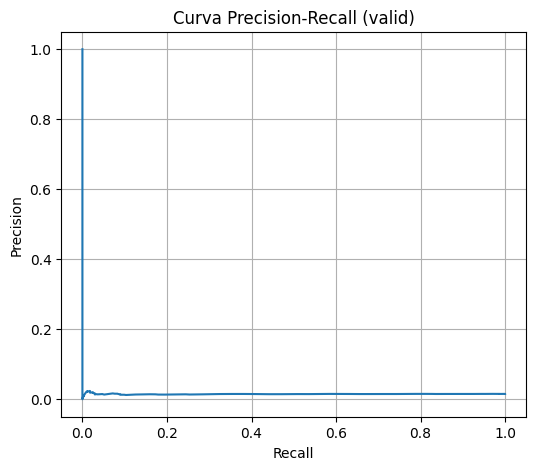

In [7]:
precision, recall, thresholds = precision_recall_curve(y_valid, y_valid_proba)

plt.figure(figsize=(6,5))
plt.plot(recall, precision)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Curva Precision-Recall (valid)")
plt.grid(True)
plt.show()


Percentiles prob_clase1 en valid:
p50: 0.16
p75: 0.19333333333333333
p90: 0.22666666666666666
p95: 0.25
p99: 0.3
p99.5: 0.32


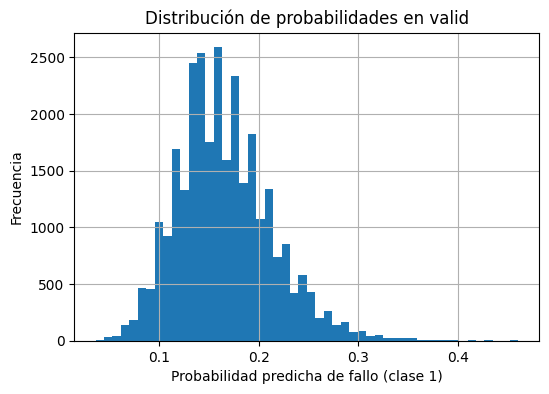

In [8]:
print("Percentiles prob_clase1 en valid:")
for p in [50, 75, 90, 95, 99, 99.5]:
    print(f"p{p}: {np.percentile(y_valid_proba, p)}")

plt.figure(figsize=(6,4))
plt.hist(y_valid_proba, bins=50)
plt.xlabel("Probabilidad predicha de fallo (clase 1)")
plt.ylabel("Frecuencia")
plt.title("Distribución de probabilidades en valid")
plt.grid(True)
plt.show()

In [9]:
from sklearn.metrics import confusion_matrix, classification_report

def evaluar_umbral(y_true, y_proba, threshold):
    y_pred_thr = (y_proba >= threshold).astype(int)
    cm = confusion_matrix(y_true, y_pred_thr)
    print(f"\n===== UMBRAL {threshold:.3f} =====")
    print("Matriz de confusión:\n", cm)
    print(classification_report(y_true, y_pred_thr, digits=3))

# Prueba con varios umbrales más bajos que 0.5
for thr in [0.50, 0.20, 0.10, 0.05, 0.02, 0.01]:
    evaluar_umbral(y_valid, y_valid_proba, thr)



===== UMBRAL 0.500 =====
Matriz de confusión:
 [[28927     0]
 [  446     0]]
              precision    recall  f1-score   support

         0.0      0.985     1.000     0.992     28927
         1.0      0.000     0.000     0.000       446

    accuracy                          0.985     29373
   macro avg      0.492     0.500     0.496     29373
weighted avg      0.970     0.985     0.977     29373


===== UMBRAL 0.200 =====
Matriz de confusión:
 [[22440  6487]
 [  359    87]]
              precision    recall  f1-score   support

         0.0      0.984     0.776     0.868     28927
         1.0      0.013     0.195     0.025       446

    accuracy                          0.767     29373
   macro avg      0.499     0.485     0.446     29373
weighted avg      0.970     0.767     0.855     29373


===== UMBRAL 0.100 =====
Matriz de confusión:
 [[ 1621 27306]
 [   25   421]]
              precision    recall  f1-score   support

         0.0      0.985     0.056     0.106     28927


c:\Users\Sergio\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\Sergio\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\Sergio\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(

### Evaluación del Random Forest (modelo base)

- **Matriz de confusión** en el conjunto de validación:
  - Todos los ejemplos se predicen como "no fallo" (clase 0).
  - Resultado: 28.927 verdaderos negativos, 446 falsos negativos, 0 verdaderos positivos y 0 falsos positivos.
  - Esto implica que el modelo no es capaz de detectar ni un solo fallo real.

- **Métricas clave con umbral 0.5**:
  - Recall de la clase 1 (fallos): 0.0 → el modelo no detecta ningún fallo.
  - Precision de la clase 1: 0.0 → no hay predicciones positivas correctas.
  - ROC‑AUC ≈ 0.49 y PR‑AUC ≈ 0.015 → el modelo apenas mejora al azar al ordenar ejemplos por probabilidad de fallo.

- **Ajuste de umbral**:
  - Al bajar el umbral (0.2, 0.1, 0.05, etc.) se observa un comportamiento extremo:
    - O bien no se detecta ningún fallo (recall ≈ 0, precisión alta pero inútil).
    - O bien se predice casi todo como fallo (recall cercano a 1 pero precisión muy baja).
  - No aparece una zona de compromiso razonable entre recall y precisión que sea útil para negocio.

- **Conclusión**:
  - El modelo no captura patrones diferenciadores robustos entre estados de "fallo" y "no fallo" en los datos actuales.
  - Desde el punto de vista operativo, un sistema que no detecta fallos o que genera casi todo como alarma no es utilizable para mantenimiento predictivo.
  - Por tanto, este Random Forest base se descarta como solución final y solo se considera un primer experimento exploratorio. Es necesario ajustar la configuración y/o probar modelos más adecuados (por ejemplo, boosting) y/o enriquecer las features antes de plantear resultados a negocio.
